In [1]:
# load the dataset
import pandas as pd
import numpy as np
import os

signals = []

for file in os.listdir('intertial_signals'):
    data = pd.read_csv(os.path.join('intertial_signals', file), sep=r"\s+", header=None)
    signals.append(data)

data = np.stack(signals, axis=-1)
y = pd.read_csv('y_train.txt', sep=r"\s+", header=None).squeeze()
subjects = pd.read_csv('subject_train.txt', sep=r"\s+", header=None).squeeze()

In [80]:
# subject disjoint split

unique = np.unique(subjects)
np.random.seed(42)

train_subjects = np.random.choice(unique, size=int(0.8 * len(unique)), replace=False)
val_subjects = np.setdiff1d(unique, train_subjects)

train_mask = np.isin(subjects, train_subjects)
val_mask = np.isin(subjects, val_subjects)

X_train = data[train_mask]
y_train = y[train_mask]

X_val = data[val_mask]
y_val = y[val_mask]

# normalize X_train and X_val
mean = X_train.mean(axis=(0, 1), keepdims=True)
std = X_train.std(axis=(0, 1), keepdims=True)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

overlap = set(train_subjects).intersection(set(val_subjects))
print("Overlap count:", len(overlap))

Overlap count: 0


In [84]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Reshape data for MLP
n_samples, n_timesteps, n_features = X_train.shape
X_train_r = X_train.reshape(n_samples, n_timesteps * n_features)

n_samples_val, n_timesteps_val, n_features_val = X_val.shape
X_val_r = X_val.reshape(n_samples_val, n_timesteps_val * n_features_val)

mlp = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1, random_state=42, warm_start=True, solver='adam')
epochs = 30
train_losses = []
val_losses = []
for i in range(epochs):
    mlp.fit(X_train_r, y_train)

    # training loss (already computed during fit)
    train_losses.append(mlp.loss_)

    # validation log loss (stable)
    val_proba = mlp.predict_proba(X_val_r)
    val_losses.append(log_loss(y_val, val_proba))  # handles clipping internally

C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the opti

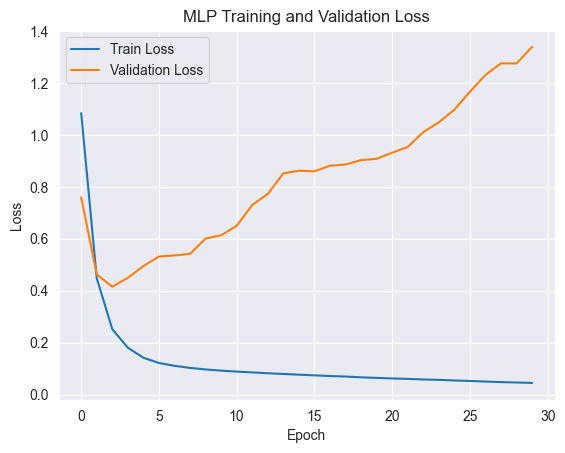

In [85]:
# plot train/val loss curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.show()

In [86]:
# Accuracy and loss on validation set

y_pred_mlp = mlp.predict(X_val_r)
print(classification_report(y_val, y_pred_mlp))

# print loss
val_proba = mlp.predict_proba(X_val_r)
print("Validation Log Loss:", log_loss(y_val, val_proba))
# predict train loss
train_proba = mlp.predict_proba(X_train_r)
print("Train Log Loss:", log_loss(y_train, train_proba))

              precision    recall  f1-score   support

           1       0.93      0.75      0.83       291
           2       0.69      0.97      0.81       256
           3       0.96      0.71      0.82       239
           4       0.83      0.82      0.82       299
           5       0.82      0.86      0.84       318
           6       1.00      1.00      1.00       320

    accuracy                           0.86      1723
   macro avg       0.87      0.85      0.85      1723
weighted avg       0.87      0.86      0.86      1723

Validation Log Loss: 1.3380287592419742
Train Log Loss: 0.04019749079097641


In [87]:
from sklearn.metrics import classification_report
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss

# Reshape data for MLP
n_samples, n_timesteps, n_features = X_train.shape
X_train_r = X_train.reshape(n_samples, n_timesteps * n_features)

n_samples_val, n_timesteps_val, n_features_val = X_val.shape
X_val_r = X_val.reshape(n_samples_val, n_timesteps_val * n_features_val)

mlp = MLPClassifier(hidden_layer_sizes=(32,), max_iter=10, random_state=42, warm_start=True, alpha=1e-4)
epochs = 30
train_losses = []
val_losses = []
best_loss = float("inf")
early_stop_count = 0
import copy

for i in range(epochs):
    mlp.fit(X_train_r, y_train)

    train_losses.append(mlp.loss_)

    val_proba = mlp.predict_proba(X_val_r)
    val_loss = log_loss(y_val, val_proba)
    val_losses.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        best_model = copy.deepcopy(mlp)
        early_stop_count = 0
    else:
        early_stop_count += 1
        if early_stop_count > 3:
            print("Early stopping at epoch", i, f"Loss: Validation {val_loss}, Train {mlp.loss_}")
            mlp = best_model
            break

    # training loss (already computed during fit)
    train_losses.append(mlp.loss_)

    # validation log loss (stable)
    val_proba = mlp.predict_proba(X_val_r)
    val_losses.append(log_loss(y_val, val_proba))  # handles clipping internally

C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the 

Early stopping at epoch 4 Loss: Validation 1.277120941567009, Train 0.029794064433906014


C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


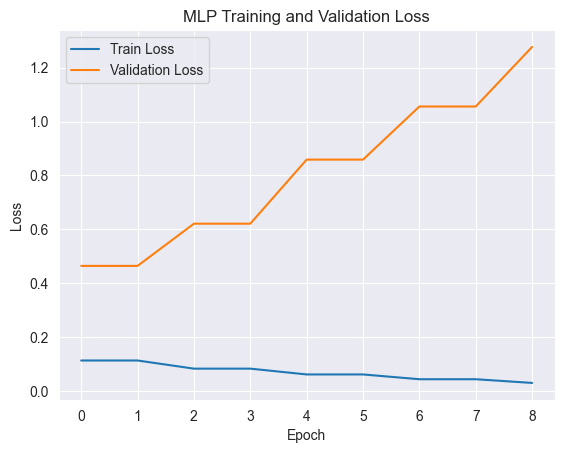

In [88]:
# plot train/val loss curves
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss')
plt.legend()
plt.show()

In [89]:
from sklearn.metrics import accuracy_score

y_pred = best_model.predict(X_val_r)
acc = accuracy_score(y_val, y_pred)

print("Validation Accuracy:", acc)

Validation Accuracy: 0.8769587928032502


In [90]:
mlp_highLR = MLPClassifier(hidden_layer_sizes=(32,), max_iter=1, random_state=42, warm_start=True, solver='adam', learning_rate_init=0.01)
epochs = 50
train_losses_lr = []
val_losses_lr = []
for i in range(epochs):
    mlp_highLR.fit(X_train_r, y_train)

    # training loss (already computed during fit)
    train_losses_lr.append(mlp_highLR.loss_)

    # validation log loss (stable)
    val_proba = mlp_highLR.predict_proba(X_val_r)
    val_losses_lr.append(log_loss(y_val, val_proba))  # handles clipping internally

C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\taylon4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the opti

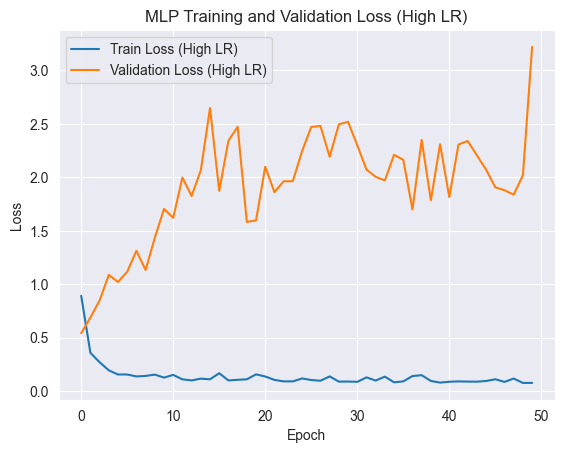

In [91]:
# Plot train/val loss curves for high learning rate
plt.plot(train_losses_lr, label='Train Loss (High LR)')
plt.plot(val_losses_lr, label='Validation Loss (High LR)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('MLP Training and Validation Loss (High LR)')
plt.legend()
plt.show()

In [92]:
# accuracy and loss on validation set for high learning rate
y_pred_mlp_lr = mlp_highLR.predict(X_val_r)
print(classification_report(y_val, y_pred_mlp_lr))

# print loss
val_proba_lr = mlp_highLR.predict_proba(X_val_r)
# train loss
train_proba_lr = mlp_highLR.predict_proba(X_train_r)
print("Validation Log Loss (High LR):", log_loss(y_val, val_proba_lr))
print("Train Log Loss (High LR):", log_loss(y_train, train_proba_lr))


              precision    recall  f1-score   support

           1       0.95      0.78      0.86       291
           2       0.69      0.97      0.81       256
           3       0.90      0.76      0.83       239
           4       0.67      0.75      0.71       299
           5       0.79      0.90      0.84       318
           6       1.00      0.71      0.83       320

    accuracy                           0.81      1723
   macro avg       0.83      0.81      0.81      1723
weighted avg       0.84      0.81      0.81      1723

Validation Log Loss (High LR): 3.2185842847238915
Train Log Loss (High LR): 0.7521080058598971


In [103]:
# Fix for this issue:
mlp_fixed = MLPClassifier(hidden_layer_sizes=(64,), max_iter=500, random_state=42, solver='adam', learning_rate_init=0.001, early_stopping=True, alpha=0.15)
mlp_fixed.fit(X_train_r, y_train)

MLPClassifier(alpha=0.15, early_stopping=True, hidden_layer_sizes=(64,),
              max_iter=500, random_state=42)

In [104]:
# Accuracy report
y_pred_mlp_fixed = mlp_fixed.predict(X_val_r)
print(classification_report(y_val, y_pred_mlp_fixed))

#print final loss
val_proba_fixed = mlp_fixed.predict_proba(X_val_r)
train_proba_fixed = mlp_fixed.predict_proba(X_train_r)
print("Validation Log Loss (Fixed):", log_loss(y_val, val_proba_fixed))
print("Train Log Loss (Fixed):", log_loss(y_train, train_proba_fixed))



              precision    recall  f1-score   support

           1       0.94      0.78      0.86       291
           2       0.71      0.98      0.83       256
           3       1.00      0.79      0.88       239
           4       0.84      0.90      0.87       299
           5       0.88      0.84      0.86       318
           6       1.00      1.00      1.00       320

    accuracy                           0.88      1723
   macro avg       0.90      0.88      0.88      1723
weighted avg       0.90      0.88      0.89      1723

Validation Log Loss (Fixed): 0.43371160585590784
Train Log Loss (Fixed): 0.07333670263543564
